In [3]:
import pandas as pd
import numpy as np
import pyBigWig
import pysam
from typing import List, Tuple, Dict
import os
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

os.chdir("/beegfs/scratch/ric.broccoli/kubacki.michal/SRF_MeCP2_CUTandTAG/Cross_final/src")
from analyze_methylation_enrichment import *

In [4]:
# Set paths
base_dir = "/beegfs/scratch/ric.broccoli/kubacki.michal/SRF_MeCP2_CUTandTAG/Cross_final/data"
medip_dir = "/beegfs/scratch/ric.broccoli/kubacki.michal/DATA/MECP2/MEDIP/output_done/bigwig"
smarcb1_dir = "/beegfs/scratch/ric.broccoli/kubacki.michal/SRF_MeCP2_SMARCB1/results/bigwig"
genome_fasta = "/beegfs/scratch/ric.broccoli/kubacki.michal/SRF_MeCP2_CUTandTAG/DATA/mm10.fa"
output_dir = "/beegfs/scratch/ric.broccoli/kubacki.michal/SRF_MeCP2_CUTandTAG/Cross_final/results/methylation_analysis"

In [5]:
# Load gene lists
gene_lists = load_gene_lists(base_dir)

In [7]:
gene_lists['up'].head()

,Gene,seqnames,start,end,distanceToTSS,geneId
1,2810029C07Rik,chr12,111574329,111575376,0.0,100504687.0
2,2900026A02Rik,chr5,113137765,113138844,0.0,243219.0
3,2900026A02Rik,chr5,113220579,113221436,0.0,243219.0
5,6330403K07Rik,chr11,71033181,71033484,29.0,103712.0
6,9930014A18Rik,chr15,60822970,60825075,0.0,320469.0


In [8]:
# Run analysis
results = analyze_methylation_and_smarcb1(
    gene_lists, medip_dir, smarcb1_dir, genome_fasta
)

Processing up genes...


100%|█████████████████████████████████████████████████████████████████████████████| 602/602 [00:24<00:00, 24.12it/s]


Processing down genes...


100%|█████████████████████████████████████████████████████████████████████████████| 323/323 [00:06<00:00, 50.65it/s]


Processing no_deg genes...


100%|███████████████████████████████████████████████████████████████████████████| 1185/1185 [00:20<00:00, 58.17it/s]


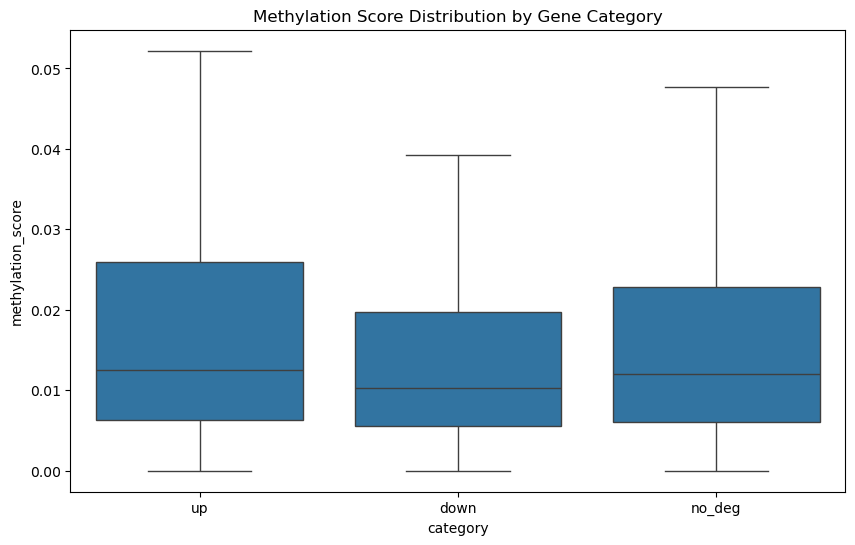

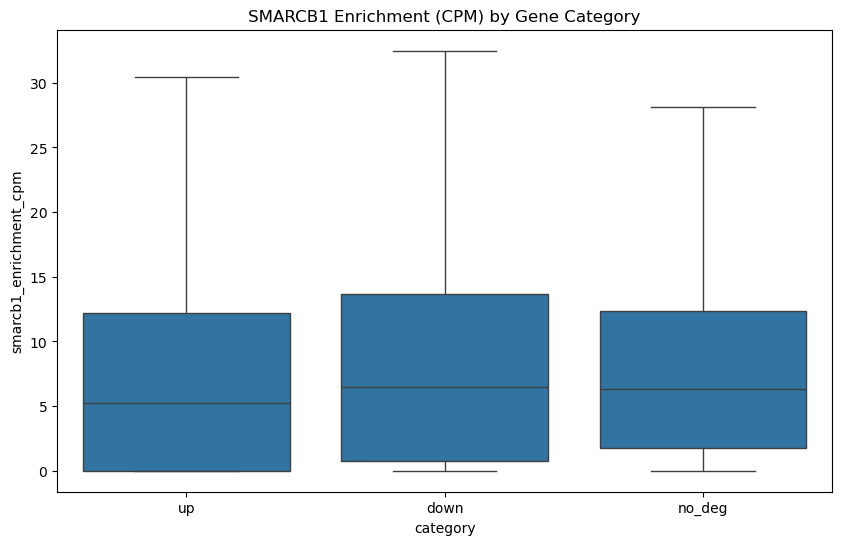

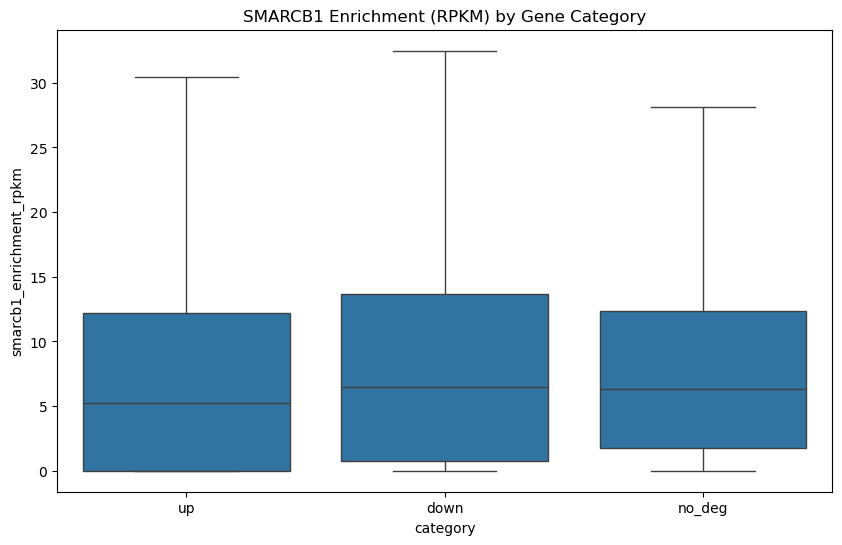

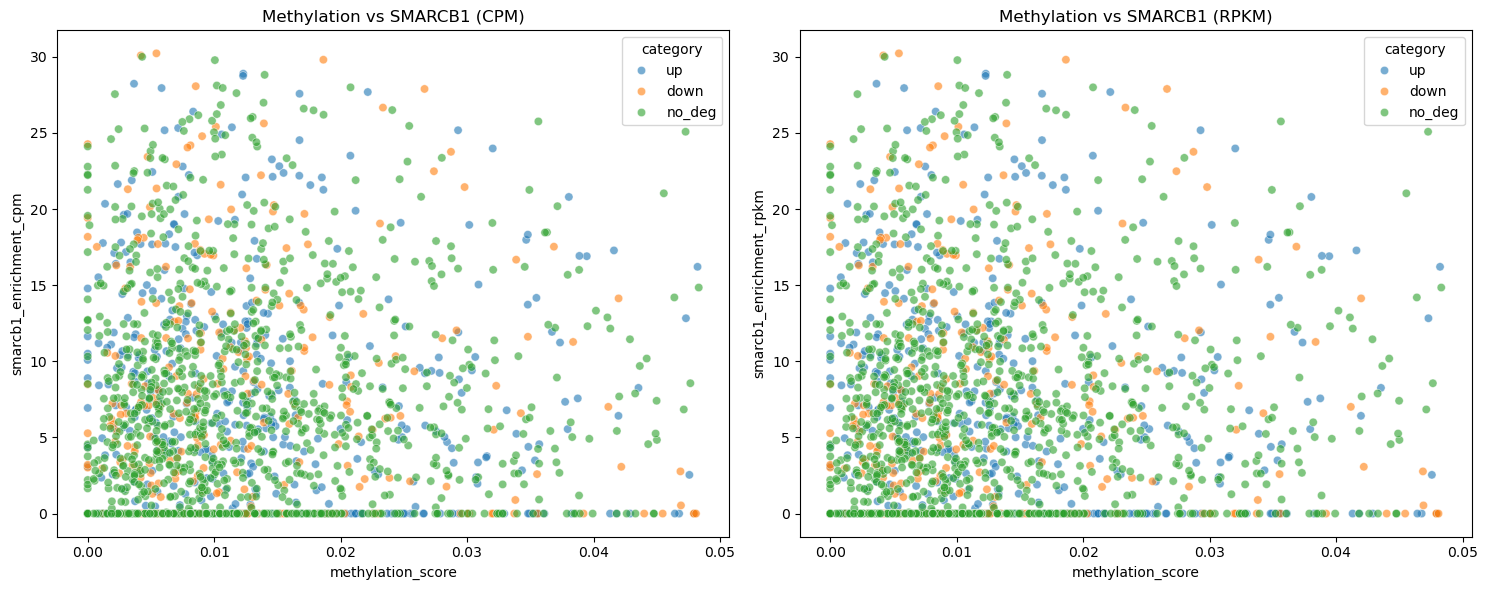

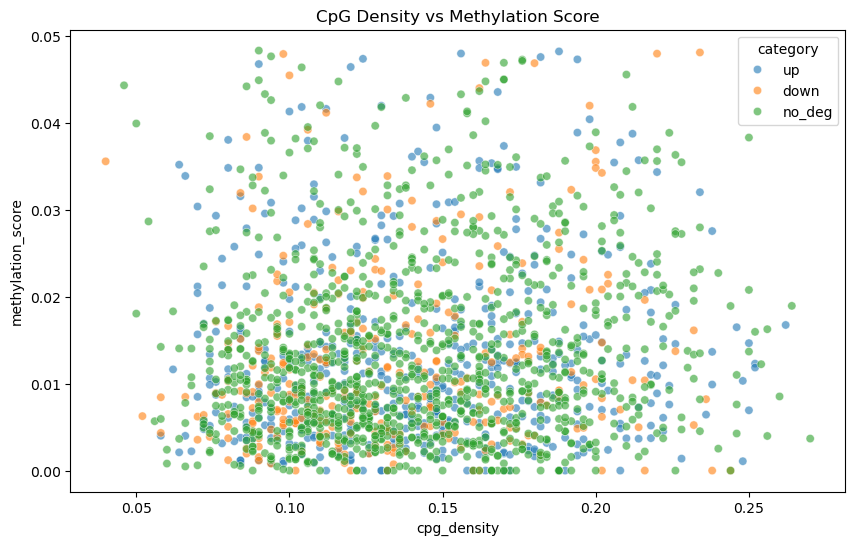

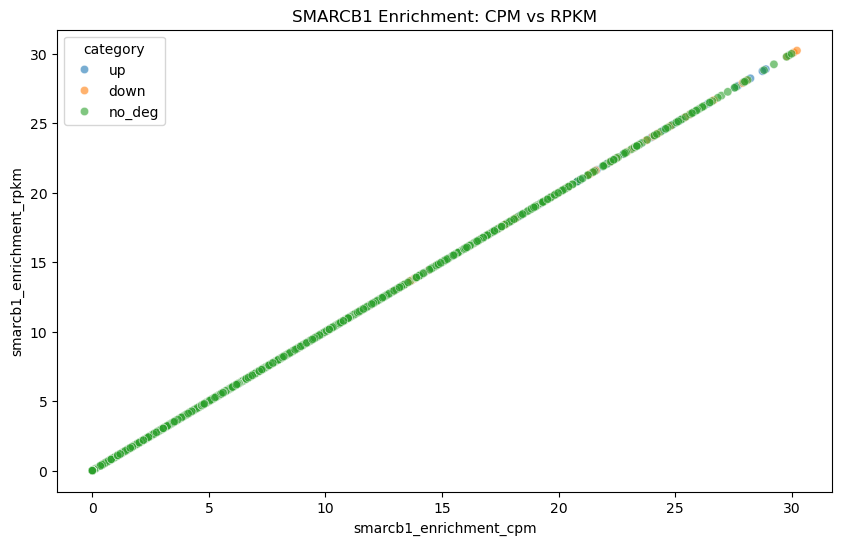

In [11]:
def plot_results(results: pd.DataFrame, plt_type: str, output_dir: str):
    """Create visualization plots for the analysis results."""
    
    # Helper function to remove outliers using IQR method
    def remove_outliers(df, cols):
        df_clean = df.copy()
        for col in cols:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            df_clean = df_clean[~((df_clean[col] < (Q1 - 1.5 * IQR)) | 
                                (df_clean[col] > (Q3 + 1.5 * IQR)))]
        return df_clean
    
    # 1. Methylation distribution by category
    if(plt_type == "Methylation distribution"):
        plt.figure(figsize=(10, 6))
        sns.boxplot(data=results, x='category', y='methylation_score', showfliers=False)
        plt.title('Methylation Score Distribution by Gene Category')
        plt.show()
    
    # 2. SMARCB1 enrichment by category (CPM)
    if(plt_type == "SMARCB1 enrichment (CPM)"):
        plt.figure(figsize=(10, 6))
        sns.boxplot(data=results, x='category', y='smarcb1_enrichment_cpm', showfliers=False)
        plt.title('SMARCB1 Enrichment (CPM) by Gene Category')
        plt.show()
    
    # 3. SMARCB1 enrichment by category (RPKM)
    if(plt_type == "SMARCB1 enrichment (RPKM)"):
        plt.figure(figsize=(10, 6))
        sns.boxplot(data=results, x='category', y='smarcb1_enrichment_rpkm', showfliers=False)
        plt.title('SMARCB1 Enrichment (RPKM) by Gene Category')
        plt.show()
    
    # 4. Methylation vs SMARCB1 enrichment scatter plots
    if(plt_type == "Methylation vs SMARCB1 enrichment"):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        results_clean = remove_outliers(results, ['methylation_score', 
                                                'smarcb1_enrichment_cpm',
                                                'smarcb1_enrichment_rpkm'])
        
        sns.scatterplot(data=results_clean, x='methylation_score', y='smarcb1_enrichment_cpm', 
                        hue='category', alpha=0.6, ax=ax1)
        ax1.set_title('Methylation vs SMARCB1 (CPM)')
        
        sns.scatterplot(data=results_clean, x='methylation_score', y='smarcb1_enrichment_rpkm', 
                        hue='category', alpha=0.6, ax=ax2)
        ax2.set_title('Methylation vs SMARCB1 (RPKM)')
        
        plt.tight_layout()
        plt.show()
    
    # 5. CpG density vs Methylation
    if(plt_type == "CpG density vs Methylation"):
        plt.figure(figsize=(10, 6))
        results_clean = remove_outliers(results, ['cpg_density', 'methylation_score'])
        sns.scatterplot(data=results_clean, x='cpg_density', y='methylation_score',
                        hue='category', alpha=0.6)
        plt.title('CpG Density vs Methylation Score')
        plt.show()
    
    # 6. Correlation between CPM and RPKM enrichment
    if(plt_type == "SMARCB1 Enrichment: CPM vs RPKM"):
        plt.figure(figsize=(10, 6))
        results_clean = remove_outliers(results, ['smarcb1_enrichment_cpm', 
                                                'smarcb1_enrichment_rpkm'])
        sns.scatterplot(data=results_clean, x='smarcb1_enrichment_cpm', y='smarcb1_enrichment_rpkm',
                        hue='category', alpha=0.6)
        plt.title('SMARCB1 Enrichment: CPM vs RPKM')
        plt.show()

# Create plots
plot_results(results, "Methylation distribution", output_dir)
plot_results(results, "SMARCB1 enrichment (CPM)", output_dir)
plot_results(results, "SMARCB1 enrichment (RPKM)", output_dir)
plot_results(results, "Methylation vs SMARCB1 enrichment", output_dir)
plot_results(results, "CpG density vs Methylation", output_dir)
plot_results(results, "SMARCB1 Enrichment: CPM vs RPKM", output_dir)

In [ ]:
# Save results
results.to_csv(os.path.join(output_dir, 'methylation_smarcb1_results.csv'), index=False)